In [2]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import davies_bouldin_score, silhouette_score, calinski_harabasz_score
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA
import warnings
warnings.filterwarnings('ignore')

In [3]:
def create_clustering_features(customers_df, transactions_df, products_df):
    """Create features for clustering analysis."""
    
    # Merge transactions with products
    transactions_df = transactions_df.rename(columns={'Price': 'TransactionPrice'})
    products_df = products_df.rename(columns={'Price': 'BasePrice'})
    trans_prod = transactions_df.merge(products_df, on='ProductID')
    
    # 1. Purchase Behavior Features
    purchase_features = trans_prod.groupby('CustomerID').agg({
        'TransactionID': 'count',
        'TotalValue': ['sum', 'mean', 'std'],
        'Quantity': ['sum', 'mean'],
        'TransactionPrice': ['mean', 'std']
    }).fillna(0)
    
    purchase_features.columns = [
        'transaction_count', 'total_spend', 'avg_transaction', 'std_transaction',
        'total_quantity', 'avg_quantity', 'avg_price', 'price_std'
    ]
    
    # 2. Category Preferences
    category_features = pd.pivot_table(
        trans_prod,
        values='TotalValue',
        index='CustomerID',
        columns='Category',
        aggfunc='sum',
        fill_value=0
    )
    
    category_totals = category_features.sum(axis=1)
    category_percentages = category_features.div(category_totals, axis=0).fillna(0)
    category_percentages.columns = [f'cat_pct_{col.lower().replace(" ", "_")}' 
                                  for col in category_percentages.columns]
    
    # 3. Time-based Features
    transactions_df['TransactionDate'] = pd.to_datetime(transactions_df['TransactionDate'])
    time_features = transactions_df.groupby('CustomerID').agg({
        'TransactionDate': ['min', 'max']
    })
    time_features.columns = ['first_purchase', 'last_purchase']
    time_features['days_active'] = (
        time_features['last_purchase'] - time_features['first_purchase']
    ).dt.days
    
    # 4. Region Features
    region_features = pd.get_dummies(customers_df.set_index('CustomerID')['Region'], 
                                   prefix='region')
    
    # Combine all features
    clustering_features = pd.concat([
        purchase_features,
        category_percentages,
        region_features,
        time_features['days_active']
    ], axis=1).fillna(0)
    
    return clustering_features

def find_optimal_clusters(features_scaled, max_clusters=10):
    """Find optimal number of clusters using multiple metrics."""
    
    metrics = {
        'db_index': [],
        'silhouette': [],
        'calinski': []
    }
    
    for n_clusters in range(2, max_clusters + 1):
        kmeans = KMeans(n_clusters=n_clusters, random_state=42)
        labels = kmeans.fit_predict(features_scaled)
        
        # Calculate metrics
        metrics['db_index'].append(davies_bouldin_score(features_scaled, labels))
        metrics['silhouette'].append(silhouette_score(features_scaled, labels))
        metrics['calinski'].append(calinski_harabasz_score(features_scaled, labels))
    
    return metrics

def plot_clustering_metrics(metrics):
    """Plot clustering evaluation metrics."""
    
    fig, axes = plt.subplots(1, 3, figsize=(15, 5))
    
    # Davies-Bouldin Index (lower is better)
    axes[0].plot(range(2, len(metrics['db_index']) + 2), metrics['db_index'], marker='o')
    axes[0].set_title('Davies-Bouldin Index\n(lower is better)')
    axes[0].set_xlabel('Number of Clusters')
    
    # Silhouette Score (higher is better)
    axes[1].plot(range(2, len(metrics['silhouette']) + 2), metrics['silhouette'], marker='o')
    axes[1].set_title('Silhouette Score\n(higher is better)')
    axes[1].set_xlabel('Number of Clusters')
    
    # Calinski-Harabasz Index (higher is better)
    axes[2].plot(range(2, len(metrics['calinski']) + 2), metrics['calinski'], marker='o')
    axes[2].set_title('Calinski-Harabasz Index\n(higher is better)')
    axes[2].set_xlabel('Number of Clusters')
    
    plt.tight_layout()
    plt.show()

def visualize_clusters(features_scaled, labels, feature_names):
    """Create visualizations of the clusters."""
    
    # PCA for dimensionality reduction
    pca = PCA(n_components=2)
    features_2d = pca.fit_transform(features_scaled)
    
    # Create visualization
    plt.figure(figsize=(12, 8))
    scatter = plt.scatter(features_2d[:, 0], features_2d[:, 1], c=labels, cmap='viridis')
    plt.title('Customer Segments (PCA)')
    plt.xlabel('First Principal Component')
    plt.ylabel('Second Principal Component')
    plt.colorbar(scatter, label='Cluster')
    plt.show()
    
    # Feature importance for first two components
    feature_importance = pd.DataFrame(
        pca.components_.T,
        columns=['PC1', 'PC2'],
        index=feature_names
    )
    
    plt.figure(figsize=(12, 8))
    sns.heatmap(feature_importance, cmap='RdBu', center=0)
    plt.title('Feature Importance in Principal Components')
    plt.show()

def analyze_clusters(features_df, labels):
    """Analyze characteristics of each cluster."""
    
    features_df['Cluster'] = labels
    cluster_analysis = features_df.groupby('Cluster').mean()
    
    # Select key features for visualization
    key_features = ['total_spend', 'transaction_count', 'avg_transaction', 'days_active']
    
    plt.figure(figsize=(15, 6))
    cluster_analysis[key_features].plot(kind='bar')
    plt.title('Key Metrics by Cluster')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()
    
    return cluster_analysis

def perform_clustering_analysis(customers_df, transactions_df, products_df, n_clusters=5):
    """Perform complete clustering analysis."""
    
    print("Creating clustering features...")
    features_df = create_clustering_features(customers_df, transactions_df, products_df)
    
    # Scale features
    scaler = StandardScaler()
    features_scaled = scaler.fit_transform(features_df)
    
    print("\nFinding optimal number of clusters...")
    metrics = find_optimal_clusters(features_scaled)
    plot_clustering_metrics(metrics)
    
    # Perform clustering with chosen number of clusters
    print(f"\nPerforming clustering with {n_clusters} clusters...")
    kmeans = KMeans(n_clusters=n_clusters, random_state=42)
    labels = kmeans.fit_predict(features_scaled)
    
    # Calculate final DB Index
    db_index = davies_bouldin_score(features_scaled, labels)
    silhouette = silhouette_score(features_scaled, labels)
    calinski = calinski_harabasz_score(features_scaled, labels)
    
    print(f"\nClustering Metrics:")
    print(f"Davies-Bouldin Index: {db_index:.4f}")
    print(f"Silhouette Score: {silhouette:.4f}")
    print(f"Calinski-Harabasz Index: {calinski:.4f}")
    
    # Visualize results
    print("\nGenerating visualizations...")
    visualize_clusters(features_scaled, labels, features_df.columns)
    cluster_analysis = analyze_clusters(features_df, labels)
    
    return labels, cluster_analysis, metrics


Loading data...
Creating clustering features...

Finding optimal number of clusters...


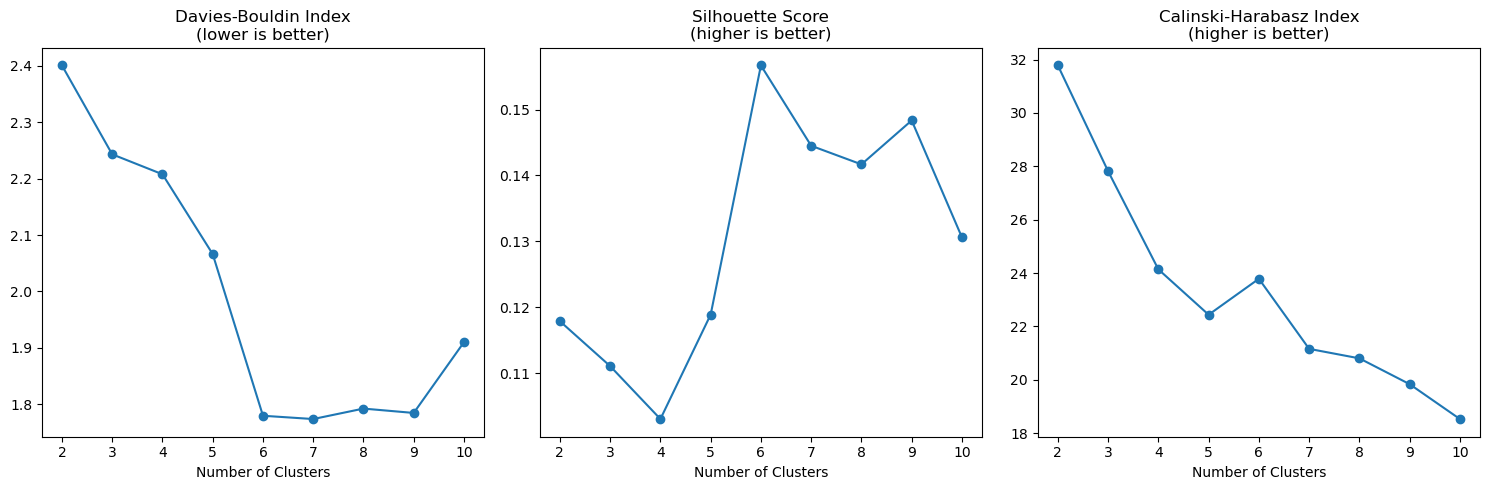


Performing clustering with 6 clusters...

Clustering Metrics:
Davies-Bouldin Index: 1.7796
Silhouette Score: 0.1567
Calinski-Harabasz Index: 23.7846

Generating visualizations...


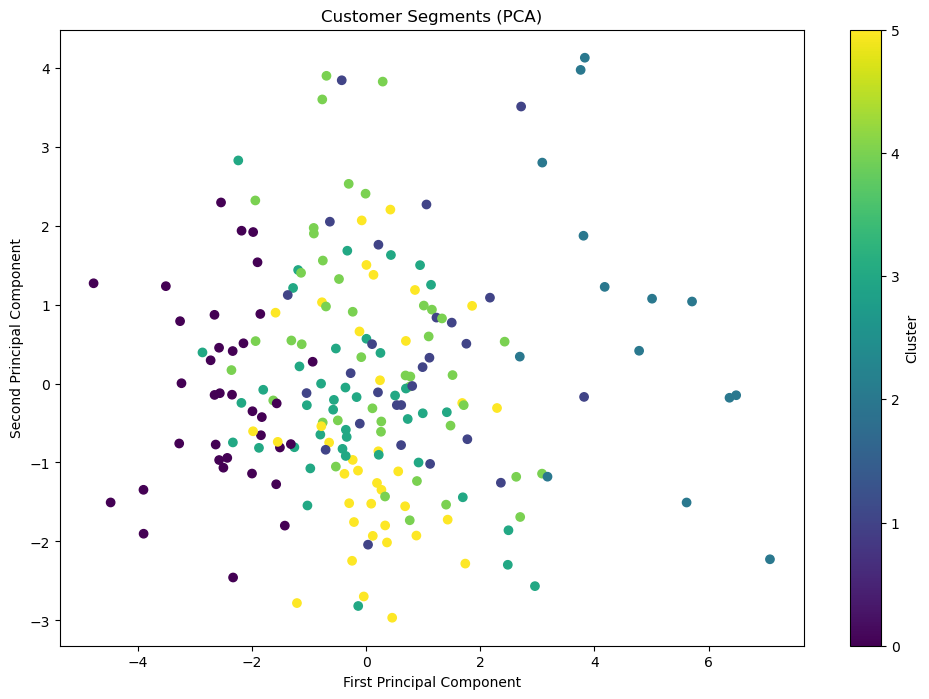

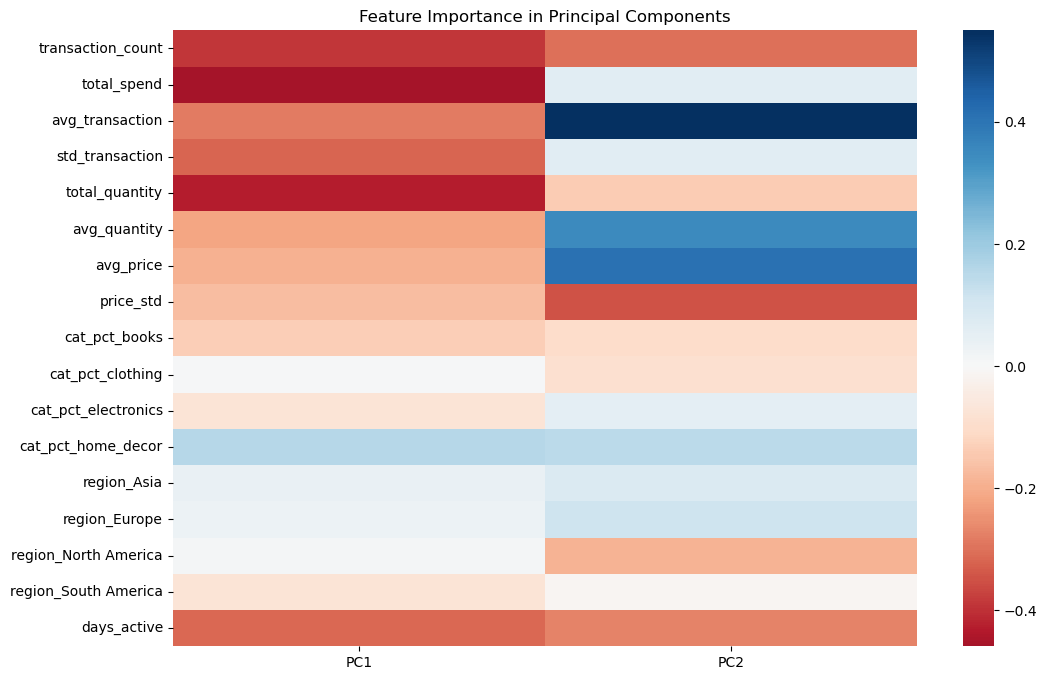

<Figure size 1500x600 with 0 Axes>

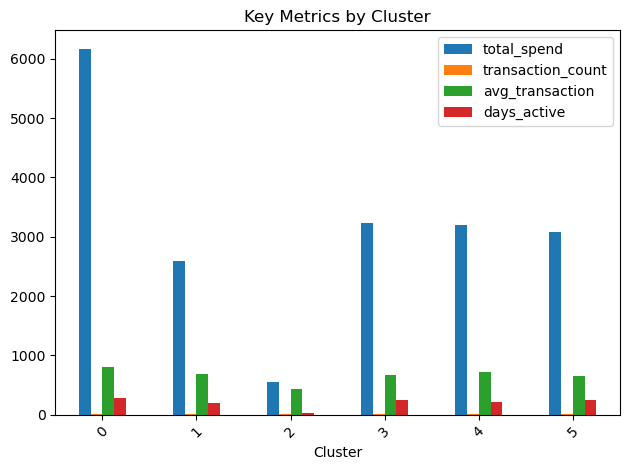

In [8]:
print("Loading data...")
customers_df = pd.read_csv('data/Customers.csv')
products_df = pd.read_csv('data/Products.csv')
transactions_df = pd.read_csv('data/Transactions.csv')

# Perform clustering analysis
labels, cluster_analysis, metrics = perform_clustering_analysis(
    customers_df, transactions_df, products_df, 6
)